In [101]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from scipy import stats
from scipy.stats import norm,skew
import warnings
from sklearn.preprocessing import RobustScaler
warnings.filterwarnings("ignore")
%matplotlib inline
# MinMaxScaler用於數據的歸一化
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score

# 讀取數據

data_path = r'C:\Users\rex\Desktop\水位預測\2\總整理.csv'
data = pd.read_csv(data_path)

print (data)
data.head(5)



             Date   Time  1510H084 Water Level  1510H076 Water Level  \
0        2020/1/1  00:00                145.30                  5.03   
1        2020/1/1  01:00                145.30                  5.11   
2        2020/1/1  02:00                145.30                  5.11   
3        2020/1/1  03:00                145.30                  5.11   
4        2020/1/1  04:00                145.30                  5.11   
...           ...    ...                   ...                   ...   
26299  2022/12/31  19:00                143.63                  4.69   
26300  2022/12/31  20:00                143.63                  4.69   
26301  2022/12/31  21:00                143.63                  4.70   
26302  2022/12/31  22:00                143.64                  4.70   
26303  2022/12/31  23:00                143.63                  4.70   

       1510H071 Water Level  1510H057 Water Level  19774 Rainfall  \
0                     20.58                 88.47             0.0 

,Date,Time,1510H084 Water Level,1510H076 Water Level,1510H071 Water Level,1510H057 Water Level,19774 Rainfall,20016 Rainfall,19606 Rainfall,19335 Rainfall
0,2020/1/1,00:00,145.3,5.03,20.58,88.47,0.0,0.0,0.0,0.000000
1,2020/1/1,01:00,145.3,5.11,20.80,88.79,0.0,0.0,0.0,0.000000
2,2020/1/1,02:00,145.3,5.11,20.81,88.78,0.0,0.0,0.0,0.000000
3,2020/1/1,03:00,145.3,5.11,20.80,88.84,0.0,0.0,0.0,0.000000
4,2020/1/1,04:00,145.3,5.11,20.79,88.81,0.0,0.0,0.0,1.428012


In [102]:
import sys
print(sys.executable)

c:\Users\rex\Anaconda3\envs\tf-GPU\python.exe


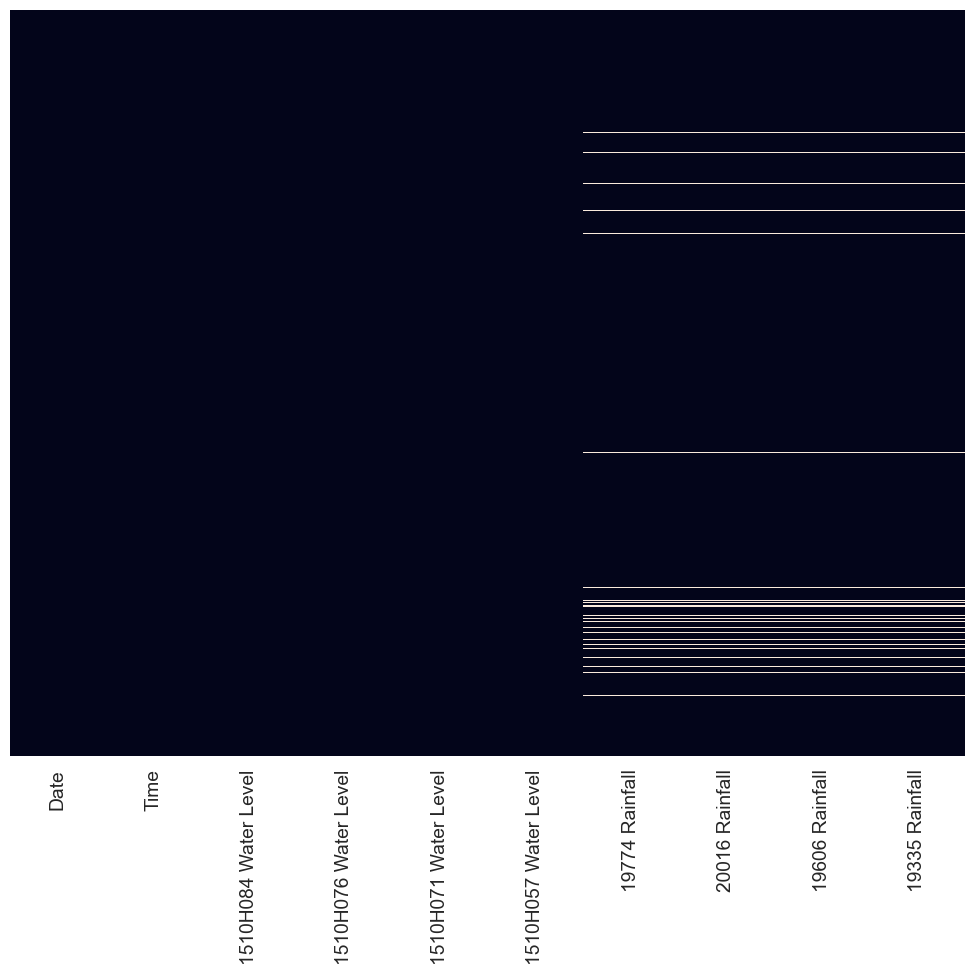

In [103]:
#isnull()看數據缺失值
plt.figure(figsize=(10,10))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False)
plt.tight_layout()
plt.show()

In [104]:
data = data.fillna(0)

In [105]:
#看數據維度
print(data.shape)
#看數據訊息
data.info()

(26304, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  26304 non-null  object 
 1   Time                  26304 non-null  object 
 2   1510H084 Water Level  26304 non-null  float64
 3   1510H076 Water Level  26304 non-null  float64
 4   1510H071 Water Level  26304 non-null  float64
 5   1510H057 Water Level  26304 non-null  float64
 6   19774 Rainfall        26304 non-null  float64
 7   20016 Rainfall        26304 non-null  float64
 8   19606 Rainfall        26304 non-null  float64
 9   19335 Rainfall        26304 non-null  float64
dtypes: float64(8), object(2)
memory usage: 2.0+ MB


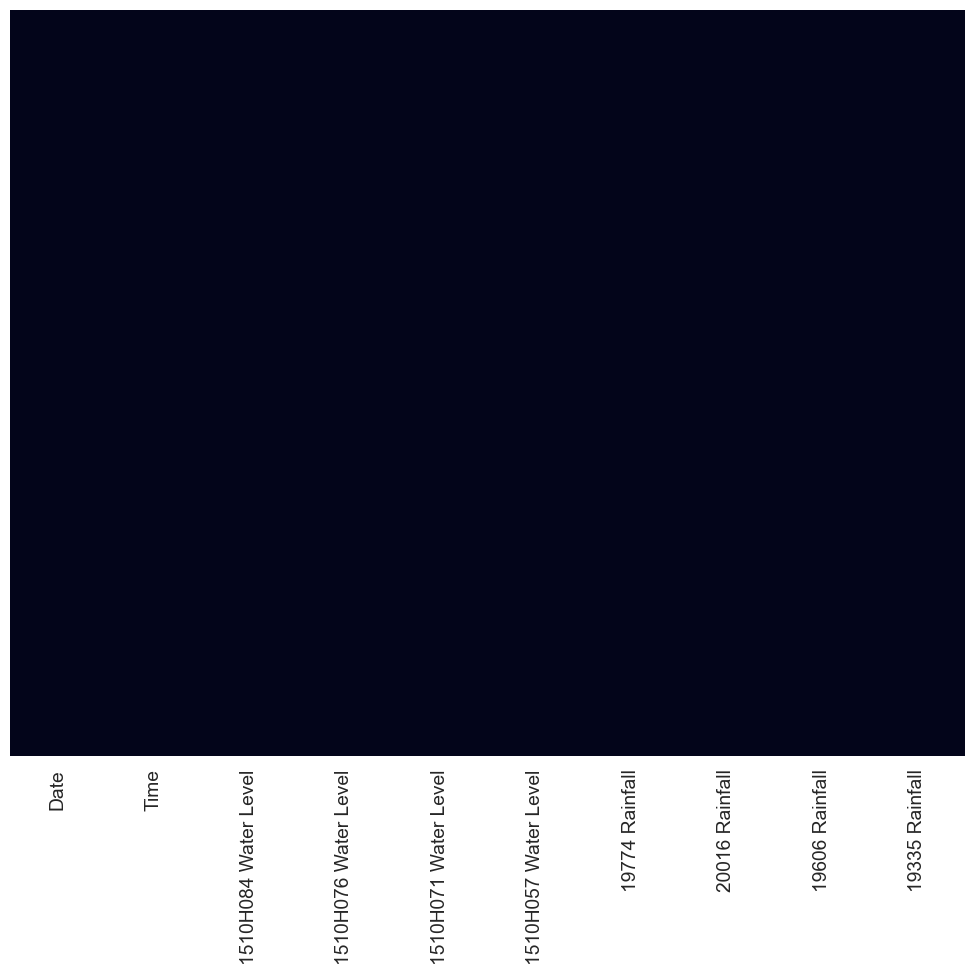

In [106]:
#isnull()看數據缺失值
plt.figure(figsize=(10,10))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False)
plt.tight_layout()
plt.show()

In [107]:
# data["Date"] = pd.to_datetime(data["Date"])

# data["Time"] = pd.to_datetime(data["Time"])

data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data.set_index('DateTime', inplace=True)
# data.drop(columns=['Date', 'Time'], inplace=True)


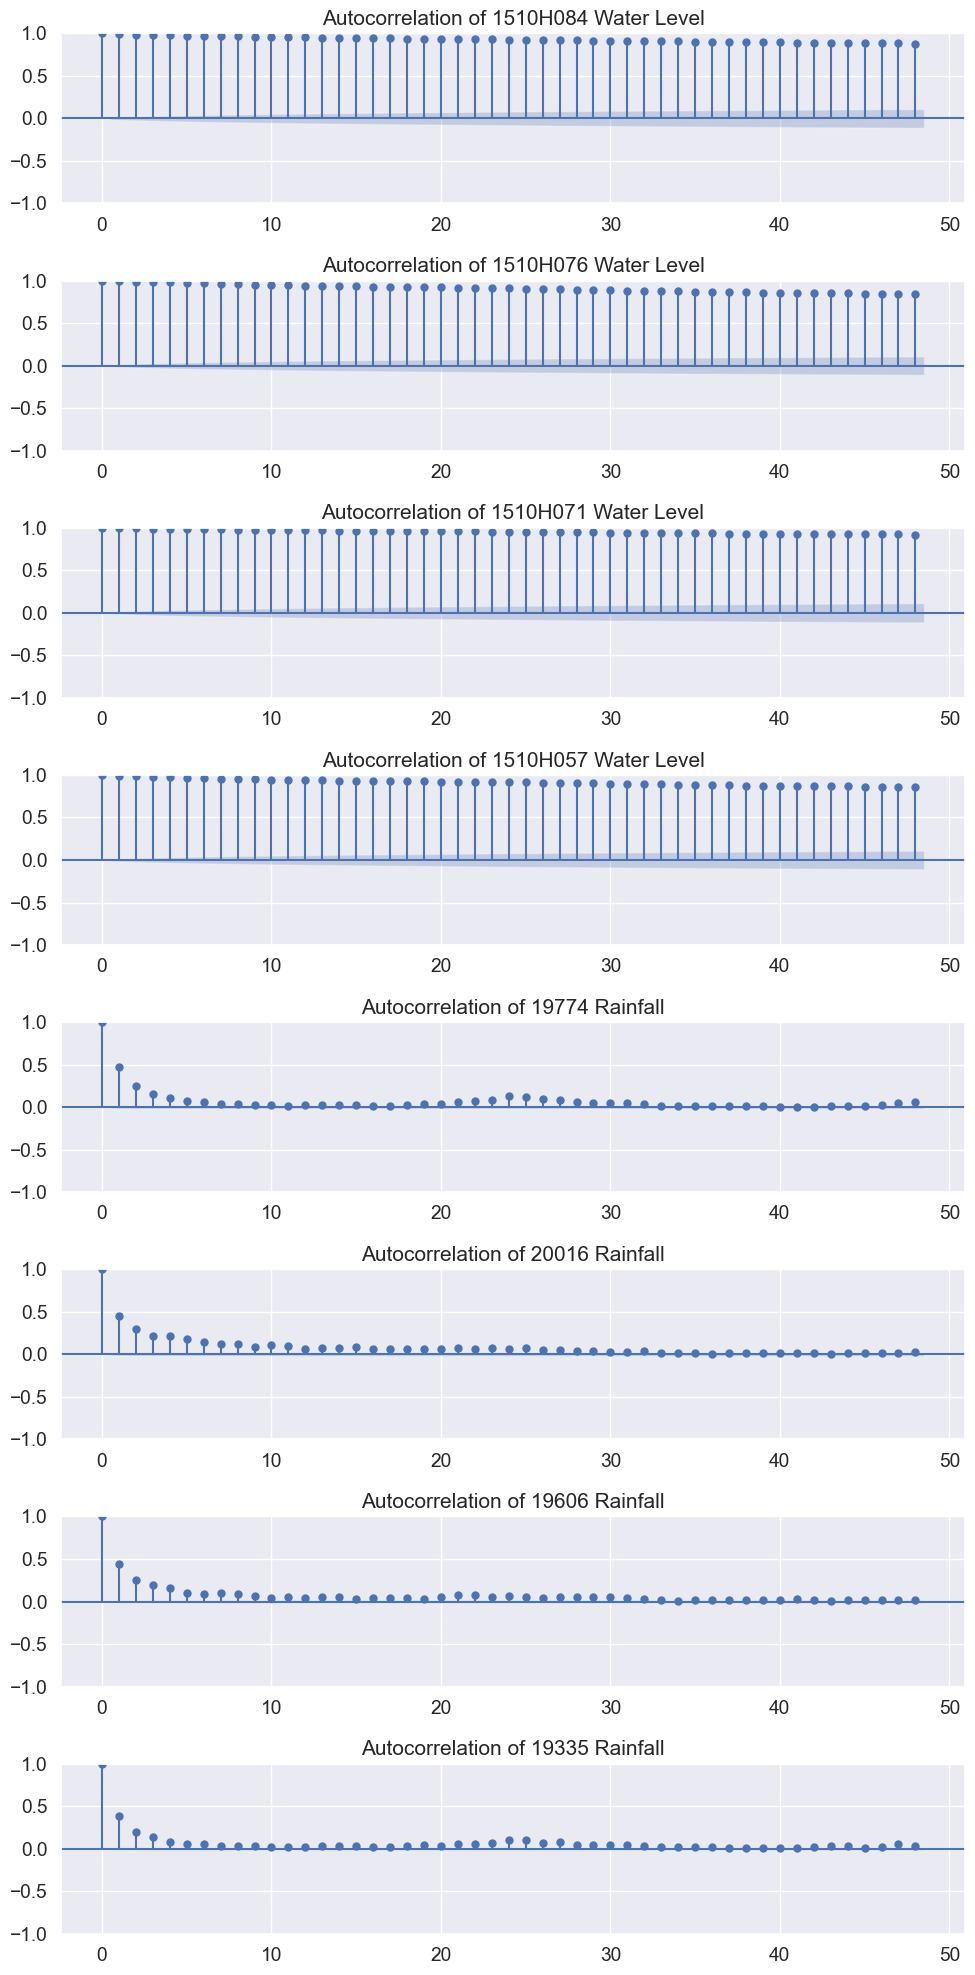

In [108]:
!pip install statsmodels
from statsmodels.graphics.tsaplots import plot_acf
# Define the list of columns to analyze
columns_to_analyze = ["1510H084 Water Level", "1510H076 Water Level", "1510H071 Water Level", "1510H057 Water Level", "19774 Rainfall", "20016 Rainfall", "19606 Rainfall", "19335 Rainfall"]

# Create a figure and axes
fig, axs = plt.subplots(len(columns_to_analyze), figsize=(10, 20))

# Generate the autocorrelation plot for each column
for ax, column in zip(axs, columns_to_analyze):
    plot_acf(data[column], ax=ax, lags=48, title=f'Autocorrelation of {column}')

# Display the plot
plt.tight_layout()
plt.show()

In [109]:
# 合併日期和時間為單一時間戳，並設為索引
data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data = data.set_index('Timestamp')

# 刪除不必要的列
data = data.drop(['Date', 'Time'], axis=1)


In [110]:
# 歸一化數據
scalers = {}
for i in data.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    s_s = scaler.fit_transform(data[i].values.reshape(-1,1))
    s_s = np.reshape(s_s, len(s_s))
    scalers['scaler_'+ i] = scaler
    data[i] = s_s

In [117]:
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 切分訓練集與測試集
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# 定義一個函數來創建輸入序列和目標序列
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# 創建輸入序列和目標序列
time_steps = 48
X_train, y_train = create_dataset(train, train, time_steps)
X_test, y_test = create_dataset(test, test, time_steps)

# 定義LSTM模型
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8))

# 調整學習率
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# 編譯模型
model.compile(optimizer=optimizer, loss='mse')

# 定義早停
early_stopping = EarlyStopping(monitor='val_loss', patience=2)  # 當驗證集上的損失在 2 個 epoch 內沒有改善時，停止訓練

# 訓練模型
history = model.fit(
    X_train, y_train,
    epochs=8,  
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=[early_stopping]  # 添加早停回調
)

# 進行預測
y_pred = model.predict(X_test)

# 將預測值和實際值的縮放反轉回來
for i in range(y_pred.shape[1]):
    y_pred[:, i] = scalers['scaler_' + data.columns[i]].inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()
    y_test[:, i] = scalers['scaler_' + data.columns[i]].inverse_transform(y_test[:, i].reshape(-1, 1)).flatten()

# 計算R^2 score
r2 = r2_score(y_test, y_pred)
print('R^2 score:', r2)

Epoch 1/8
591/591 [==============================] - 97s 163ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 2/8
591/591 [==============================] - 96s 163ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/8
102/591 [====>.........................] - ETA: 1:18 - loss: 0.0030

In [113]:
from tensorflow.keras.layers import Conv1D, LSTM, Dense
# 切分訓練集與測試集
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# 定義一個函數來創建輸入序列和目標序列
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# 創建輸入序列和目標序列
time_steps = 48
X_train, y_train = create_dataset(train, train, time_steps)
X_test, y_test = create_dataset(test, test, time_steps)

# 定義ConvLSTM模型
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(8))

# 編譯模型
model.compile(optimizer='adam', loss='mse')

# 定義早停
early_stopping = EarlyStopping(monitor='val_loss', patience=2)  # 當驗證集上的損失在 2 個 epoch 內沒有改善時，停止訓練

# 訓練模型
history = model.fit(
    X_train, y_train,
    epochs=8,  # 將 epochs 數量設為 4
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=[early_stopping]  # 添加早停回調
)

# 進行預測
y_pred = model.predict(X_test)

# 將預測值和實際值的縮放反轉回來
for i in range(y_pred.shape[1]):
    y_pred[:, i] = scalers['scaler_' + data.columns[i]].inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()
    y_test[:, i] = scalers['scaler_' + data.columns[i]].inverse_transform(y_test[:, i].reshape(-1, 1)).flatten()

# 計算R^2 score
r2 = r2_score(y_test, y_pred)
print('R^2 score:', r2)

Epoch 1/8
591/591 [==============================] - 53s 83ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 2/8
591/591 [==============================] - 49s 83ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 3/8
591/591 [==============================] - 49s 83ms/step - loss: 0.0014 - val_loss: 9.8107e-04
Epoch 4/8
591/591 [==============================] - 50s 84ms/step - loss: 0.0011 - val_loss: 8.2233e-04
Epoch 5/8
591/591 [==============================] - 49s 83ms/step - loss: 0.0010 - val_loss: 7.1259e-04
Epoch 6/8
591/591 [==============================] - 50s 85ms/step - loss: 8.5622e-04 - val_loss: 6.9078e-04
Epoch 7/8
591/591 [==============================] - 49s 83ms/step - loss: 7.2892e-04 - val_loss: 5.9781e-04
Epoch 8/8
591/591 [==============================] - 49s 83ms/step - loss: 6.7571e-04 - val_loss: 5.7891e-04
R^2 score: 0.07555546522436418
